# Ingestion

In [2]:
from sentence_transformers import SentenceTransformer
from transformers import AutoTokenizer
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
from qdrant_client import QdrantClient
from langchain_qdrant import QdrantVectorStore
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer
from typing import List, Optional  # Import List and Optional for type annotations
from langchain.docstore.document import Document as LangchainDocument
from tqdm import tqdm
import pdfplumber
import os
import openai
from langchain.embeddings import OpenAIEmbeddings  # Correct import path for OpenAI embeddings


c:\Users\fiori\OneDrive\Documenti\GitHub\RAG_BGG\.venv\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [6]:
def read_token_from_file(file_path="token.txt"):
    with open(file_path, "r") as file:
        return file.read().strip()

In [7]:
from openai import OpenAI

# Set your OpenAI API key
os.environ["OPENAI_API_KEY"] = read_token_from_file("keys/OpenAI.txt")

In [8]:
file_path = [
    "C:/Users/fiori/OneDrive/Documenti/Rulebooks/"
]
COLLECTION_NAME = "transformer_sentece_splitter_2"

URL=read_token_from_file("keys/qdrant_URL.txt")
API_KEY=read_token_from_file("keys/qdrant.txt")
# Specify the folder path
folder_path = "C:\\Users\\fiori\\OneDrive\\Documenti\\Rulebooks"
EMBEDDING_MODEL_NAME = "thenlper/gte-small"


In [9]:
def add_embeddings_to_qdrant(docs_processed, URL, API_KEY, OPENAI_KEY, collection_name="test_2"):
    """Create embeddings for documents and add them to Qdrant."""
    
    URL=URL 
    API_KEY=API_KEY
    
    if OPENAI_KEY:
        embedding_model = OpenAIEmbeddings(
            model="text-embedding-ada-002",  # Specify the desired OpenAI embedding model
        )

    else:
        embedding_model = HuggingFaceEmbeddings(
            model_name=EMBEDDING_MODEL_NAME,
            multi_process=True,  # Enable multiprocessing
            model_kwargs={"device": "cuda"},
            encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
        )


    vector_store = QdrantVectorStore.from_documents(
        docs_processed,
        embedding_model,
        url = URL,
        #prefer_grpc=True,
        api_key=API_KEY,
        collection_name=collection_name,
        force_recreate = False
    )

In [10]:
def connect_Qdrant(URL, API_KEY):
    # Initialize Qdrant client
    qdrant_client = QdrantClient(
        url=URL, 
        api_key=API_KEY,
    )
    return qdrant_client


In [11]:
def process_pdfs(path, tokenizer):
    # Load dataset from Hugging Face
    RAW_KNOWLEDGE_BASE = []

    # List the PDF files in the folder
    pdf_files = [f for f in os.listdir(path) if f.endswith(".pdf")]
    pdf_texts = []

    for pdf_file in tqdm(pdf_files):
        # Extract text from PDF using pdfplumber
        with pdfplumber.open(os.path.join(folder_path, pdf_file)) as pdf:
            text = ""
            for page in pdf.pages:
                text += page.extract_text()
        pdf_texts.append(text)

    pdf_dict = [{"game_name" : pdf_file.removesuffix(".pdf").split("_")[0], "game_id" : pdf_file.removesuffix(".pdf").split("_")[1]} for i, pdf_file in enumerate(pdf_files)]

    RAW_KNOWLEDGE_BASE = tokenizer.create_documents(
        pdf_texts,
        pdf_dict
    )

    docs_processed = tokenizer.split_documents(RAW_KNOWLEDGE_BASE)
    return docs_processed

In [12]:
def process_txt_files(path, tokenizer):
    # Load dataset
    RAW_KNOWLEDGE_BASE = []

    # List the TXT files in the folder
    txt_files = [f for f in os.listdir(path) if f.endswith(".txt")]
    txt_texts = []

    for txt_file in tqdm(txt_files):
        # Read text content from each TXT file
        with open(os.path.join(path, txt_file), 'r', encoding='utf-8') as file:
            text = file.read()
        txt_texts.append(text)

    # Create a dictionary with game names and IDs, assuming they follow a similar naming convention
    txt_dict = [{"game_name": txt_file.removesuffix(".txt").split("_")[0], "game_id": txt_file.removesuffix(".txt").split("_")[1]} for txt_file in txt_files]

    # Tokenize and create documents
    RAW_KNOWLEDGE_BASE = tokenizer.create_documents(
        txt_texts,
        txt_dict
    )

    # Split documents for downstream processing
    docs_processed = tokenizer.split_documents(RAW_KNOWLEDGE_BASE)
    return docs_processed

# UNSTRUCTURED

In [16]:
from langchain_unstructured import UnstructuredLoader
from unstructured.chunking.title import chunk_by_title


loader = UnstructuredLoader(file_paths, chunk_strategy = chunk_by_title)

NameError: name 'file_paths' is not defined

In [ ]:
docs = loader.load()

In [ ]:
docs[10].page_content

'Difficulty level:'

In [ ]:
from langchain.document_loaders import UnstructuredPDFLoader #fa un pò cagare, bisognerebbe provare l'API by_title, magari si può usare per le tabelle...

loader = UnstructuredPDFLoader("C:/Users/fiori/OneDrive/Documenti/Rulebooks/The Mind Extreme.pdf", mode="elements")
docs = loader.load()

In [ ]:
docs

[Document(metadata={'source': 'C:/Users/fiori/OneDrive/Documenti/Rulebooks/The Mind Extreme.pdf', 'coordinates': {'points': ((9.73945, 4.981999999999971), (9.73945, 30.98199999999997), (120.65519598000003, 30.98199999999997), (120.65519598000003, 4.981999999999971)), 'system': 'PixelSpace', 'layout_width': 257.95, 'layout_height': 334.49}, 'file_directory': 'C:/Users/fiori/OneDrive/Documenti/Rulebooks', 'filename': 'The Mind Extreme.pdf', 'languages': ['eng'], 'last_modified': '2024-09-29T13:58:58', 'page_number': 1, 'filetype': 'application/pdf', 'category': 'Header', 'element_id': '7d22452cb6bfb2b564695db47ac3493f'}, page_content='The Mind'),
 Document(metadata={'source': 'C:/Users/fiori/OneDrive/Documenti/Rulebooks/The Mind Extreme.pdf', 'coordinates': {'points': ((194.737, 15.110000000000014), (194.737, 29.110000000000014), (217.9882, 29.110000000000014), (217.9882, 15.110000000000014)), 'system': 'PixelSpace', 'layout_width': 257.95, 'layout_height': 334.49}, 'file_directory': 'C:

# SEMANTIC SPLITTER

In [27]:
# https://github.com/FullStackRetrieval-com/RetrievalTutorials/blob/main/tutorials/LevelsOfTextSplitting/5_Levels_Of_Text_Splitting.ipynb
#fare vector_Db con semantic e provare LLM
from langchain_experimental.text_splitter import SemanticChunker

ModuleNotFoundError: No module named 'langchain_experimental'

In [28]:
# Initialize the embedding model
# embedding_model = HuggingFaceEmbeddings(
#     model_name=EMBEDDING_MODEL_NAME,
#     multi_process=True,  # Enable multiprocessing
#     model_kwargs={"device": "cuda"},
#     encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
# )

#nvdia embeddings + nvidia reranker with API
# from langchain_nvidia_ai_endpoints import NVIDIAEmbeddings

# embedding_model = NVIDIAEmbeddings()

embedding_model = OpenAIEmbeddings(
    model="text-embedding-ada-002",  # Specify the desired OpenAI embedding model
)


semnatic_splitter = SemanticChunker(
    embedding_model, breakpoint_threshold_type="percentile"
)

C:\Users\fiori\AppData\Local\Temp\ipykernel_13000\4223327159.py:14: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings(


NameError: name 'SemanticChunker' is not defined

In [29]:
embedding_model = OpenAIEmbeddings(
    model="text-embedding-ada-002",  # Specify the desired OpenAI embedding model
)


In [ ]:
# Pass the Dataset object to the process_documents function
docs_processed = process_pdfs(folder_path, semnatic_splitter)

100%|██████████| 3/3 [00:05<00:00,  1.86s/it]


In [ ]:
docs_processed

[Document(metadata={'game_name': 'The Mind Extreme'}, page_content='The Mind\nWolfgang\nWarsch\nFor professional telepaths! Players: 2-4 people Age: 8+ Duration: app.'),
 Document(metadata={'game_name': 'The Mind Extreme'}, page_content='20 min.'),
 Document(metadata={'game_name': 'The Mind Extreme'}, page_content='What‘s new about the Extreme version? The basic rules of the original „The Mind” game are the same. In the first round\n(level 1) everyone gets 1 card, in the second round (level 2) everyone gets 2 cards,\netc.'),
 Document(metadata={'game_name': 'The Mind Extreme'}, page_content='Everyone forms one team and tries to lay all the cards they receive correctly in\nthe middle of the table. There is no player order. Anyone who wants to lay a card,\nsimply lays it. Warning: There’s not just one stack in the middle of the table\nlike with the original but two at the same time! The stack with the white numbers\nis ascending (1-50), the stack with the red numbers is descending (50-1)

In [ ]:
add_embeddings_to_qdrant(docs_processed, URL, API_KEY,OPENAI_KEY = os.environ["OPENAI_API_KEY"], collection_name="openai")

# SEMANTIC TRANSFORMER MODEL

In [ ]:
from langchain_text_splitters.sentence_transformers import SentenceTransformersTokenTextSplitter


transformer_splitter = SentenceTransformersTokenTextSplitter(
    chunk_overlap=200
)

c:\Users\fiori\OneDrive\Documenti\GitHub\ChatBot_BoardGames\venv\lib\site-packages\transformers\tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Pass the Dataset object to the process_documents function
docs_processed = process_pdfs(folder_path, transformer_splitter)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:05<00:00,  1.99s/it]


In [ ]:
len(docs_processed)

70

In [ ]:
add_embeddings_to_qdrant(docs_processed, URL, API_KEY, collection_name="transformer_sentece_splitter_2")

RECURSIVE TEXT SPLITTER

In [ ]:
#fare vector_DB con agentic chuncking e provare LLM

In [ ]:
# def split_documents(
#     chunk_size: int,
#     knowledge_base: List[LangchainDocument],
#     tokenizer_name: Optional[str] ,
# ) -> List[LangchainDocument]:
#     """
#     Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
#     """
#     text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
#         AutoTokenizer.from_pretrained(tokenizer_name),
#         chunk_size=chunk_size,
#         chunk_overlap=int(chunk_size / 10),
#         add_start_index=True,
#         strip_whitespace=True,
#         separators=MARKDOWN_SEPARATORS,
#     )

#     docs_processed = []
#     for doc in tqdm(knowledge_base):
#         docs_processed += text_splitter.split_documents([doc])

#     # Remove duplicates
#     unique_texts = {}
#     docs_processed_unique = []
#     for doc in docs_processed:
#         if doc.page_content not in unique_texts:
#             unique_texts[doc.page_content] = True
#             docs_processed_unique.append(doc)

#     return docs_processed_unique


In [ ]:
# def process_pdfs(path):
#     # Load dataset from Hugging Face
#     RAW_KNOWLEDGE_BASE = []

#     # List the PDF files in the folder
#     pdf_files = [f for f in os.listdir(path) if f.endswith(".pdf")]

#     for pdf_file in tqdm(pdf_files):
#         # Extract text from PDF using pdfplumber
#         with pdfplumber.open(os.path.join(folder_path, pdf_file)) as pdf:
#             text = ""
#             for page in pdf.pages:
#                 text += page.extract_text()
#             RAW_KNOWLEDGE_BASE.append(LangchainDocument(page_content=text, metadata={"source": pdf_file.removesuffix(".pdf")}))

#     # Process documents (split into chunks)
#     docs_processed = split_documents(
#         512,  # Chunk size adapted to the model's capabilities
#         RAW_KNOWLEDGE_BASE,
#         tokenizer_name=EMBEDDING_MODEL_NAME,
#     )
#     return docs_processed

In [ ]:
# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]


URL=read_token_from_file("keys/qdrant_URL.txt")
API_KEY=read_token_from_file("keys/qdrant.txt")
# Specify the folder path
folder_path = "C:\\Users\\fiori\\OneDrive\\Documenti\\Rulebooks"

# Pass the Dataset object to the process_documents function
docs_processed = process_pdfs(folder_path)


# Only the main process should execute this
print(f"Model's maximum sequence length: {SentenceTransformer(EMBEDDING_MODEL_NAME).max_seq_length}")

add_embeddings_to_qdrant(docs_processed, URL, API_KEY)

print("Documents and their embeddings have been successfully added to Qdrant.")

  0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████| 1/1 [00:00<00:00, 12.73it/s]


Model's maximum sequence length: 512
Documents and their embeddings have been successfully added to Qdrant.


# Chunck manually separated rulebooks

In [ ]:
from langchain_text_splitters import CharacterTextSplitter

#chunck_size forse è il minimo chunk_size non il max... per come funziona se è meno di 50 non splitta, ma il max è infinito
text_splitter = CharacterTextSplitter(
    separator="***",
    chunk_size=50,
    chunk_overlap=0,
    length_function=len,
    is_separator_regex=False,
)

path_txt = "C:\\Users\\fiori\\OneDrive\\Documenti\\Rulebooks_txt"
docs_txt = process_txt_files(path_txt, text_splitter)
docs_txt

100%|██████████| 1/1 [00:00<00:00, 1006.55it/s]
Created a chunk of size 123, which is longer than the specified 50
Created a chunk of size 765, which is longer than the specified 50
Created a chunk of size 809, which is longer than the specified 50
Created a chunk of size 2223, which is longer than the specified 50
Created a chunk of size 466, which is longer than the specified 50
Created a chunk of size 1056, which is longer than the specified 50
Created a chunk of size 496, which is longer than the specified 50
Created a chunk of size 719, which is longer than the specified 50
Created a chunk of size 994, which is longer than the specified 50
Created a chunk of size 493, which is longer than the specified 50


[Document(metadata={'game_name': 'The Mind Extreme', 'game_id': '287607'}, page_content='The Mind Extreme\nFor pofessional telepaths!\nPlayers: 2- 4 people Age: 8+ Duration: app. 20 min.\nFor professional telepaths'),
 Document(metadata={'game_name': 'The Mind Extreme', 'game_id': '287607'}, page_content='What‘s new about the Extreme version?\nThe basic rules of the original „The Mind” game are the same. In the first round \n(level 1) everyone gets 1 card, in the second round (level 2) everyone gets 2 cards, \netc. Everyone forms one team and tries to lay all the cards they receive correctly in \nthe middle of the table. There is no player order. Anyone who wants to lay a card, \nsimply lays it. Warning: There’s not just one stack in the middle of the table \nlike with the original but two at the same time! The stack with the white numbers \nis ascending (1-50), the stack with the red numbers is descending (50-1). In some \nlevels the cards even have to be laid face down in the middle 

In [ ]:
len(docs_txt)

11

In [ ]:
add_embeddings_to_qdrant(docs_txt, URL, API_KEY,OPENAI_KEY = os.environ["OPENAI_API_KEY"], collection_name="openai_txt")

C:\Users\fiori\AppData\Local\Temp\ipykernel_6588\689143979.py:8: LangChainDeprecationWarning: The class `OpenAIEmbeddings` was deprecated in LangChain 0.0.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import OpenAIEmbeddings``.
  embedding_model = OpenAIEmbeddings(


## Marker chuncking

In [1]:
from marker.convert import convert_single_pdf
from marker.models import load_all_models


models = load_all_models()
full_text, imaged, out_meta = convert_single_pdf("C:/Users/fiori/OneDrive/Documenti/Rulebooks/The Mind Extreme_287607.pdf", models, langs=['en'])

c:\Users\fiori\OneDrive\Documenti\GitHub\RAG_BGG\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loaded detection model vikp/surya_det3 on device cuda with dtype torch.float16
Loaded detection model vikp/surya_layout3 on device cuda with dtype torch.float16
Loaded reading order model vikp/surya_order on device cuda with dtype torch.float16
Loaded recognition model vikp/surya_rec2 on device cuda with dtype torch.float16
Loaded texify model to cuda with torch.float16 dtype
Loaded recognition model vikp/surya_tablerec on device cuda with dtype torch.float16


Detecting bboxes:  50%|█████     | 1/2 [00:05<00:05,  5.72s/it]c:\Users\fiori\OneDrive\Documenti\GitHub\RAG_BGG\.venv\lib\site-packages\surya\postprocessing\affinity.py:28: RuntimeWarning: invalid value encountered in cast
  scaled_sobel = np.uint8(255 * abs_sobelx / np.max(abs_sobelx))
Finding reading order: 100%|██████████| 1/1 [00:15<00:00, 15.15s/it]
Recognizing tables: 0it [00:00, ?it/s]


In [2]:
print(full_text)



{0}------------------------------------------------

What's new about the Extreme version?

The basic rules of the original "The Mind" game are the same. In the first round (level 1) everyone gets 1 card, in the second round (level 2) everyone gets 2 cards, etc. Everyone forms one team and tries to lay all the cards they receive correctly in the middle of the table. There is no player order. Anyone who wants to lay a card, simply lays it. Warning: **There's not just one stack in the middle of the table** like with the original but two at the same time! The stack with the white numbers is ascending (1-50), the stack with the red numbers is descending (50-1). In some levels the cards even have to be laid **face down** in the middle of the table, which makes the collective sense of time even more challenging.

Setting up the game The team gets a certain number of **lives and throwing stars**, which are placed face up next to each other on the table. The remaining lives and throwing star

In [3]:
out_meta

{'languages': ['en'],
 'filetype': 'pdf',
 'pdf_toc': [],
 'pages': 5,
 'ocr_stats': {'ocr_pages': 0,
  'ocr_failed': 0,
  'ocr_success': 0,
  'ocr_engine': 'none'},
 'block_stats': {'header_footer': 0,
  'code': 0,
  'table': 0,
  'equations': {'successful_ocr': 0, 'unsuccessful_ocr': 0, 'equations': 0}},
 'computed_toc': []}

In [9]:
with open("C:/Users/fiori/Downloads/spellbook.txt", "r") as file:
    full_text = file.read()

In [10]:
from langchain_text_splitters import MarkdownHeaderTextSplitter


headers_to_split = [
    ("#", "Header 1"),
    ("##", "Header 2"),
    ("###", "Header 3"),
    ("####", "Header 4"),
    ("#####", "Header 5"),
    ("######", "Header 6"),
]


text_splitter = MarkdownHeaderTextSplitter(
    headers_to_split,
    strip_headers=False
)

chunks = text_splitter.split_text(full_text)



In [12]:
len(chunks)

38

In [13]:
for doc in chunks:
    doc.metadata["game_name"] = "Spellbook"
    doc.metadata["game_id"] = "391834"

In [34]:
add_embeddings_to_qdrant(chunks, URL, os.environ["OPENAI_API_KEY"], API_KEY, collection_name="openai_txt")

UnexpectedResponse: Unexpected Response: 403 (Forbidden)
Raw response content:
b'{"error":"forbidden"}'

### LLM & Retrieval

In [ ]:
# import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device

device(type='cuda', index=0)

In [ ]:
# import os

# os.environ["LANGCHAIN_TRACING_V2"] = "true"
# os.environ["LANGCHAIN_API_KEY"] = read_token_from_file("keys/langchain.txt")

In [ ]:
# from langchain_core.prompts import ChatPromptTemplate
# from langchain_ollama.llms import OllamaLLM

# llm = OllamaLLM(model="llama3.1")

In [180]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

# Initialize GPT-3.5 Turbo using Langchain's ChatOpenAI model
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)


C:\Users\fiori\AppData\Local\Temp\ipykernel_15952\3201139575.py:5: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(model="gpt-4o-mini", temperature=0.3)


In [181]:
from langchain.chains.prompt_selector import ConditionalPromptSelector, is_chat_model
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
    SystemMessagePromptTemplate,
)
from langchain_core.output_parsers import StrOutputParser

template_string = """
System: You are Boardy, an expert assistant specializing in board games. Your role is to provide authoritative, precise, and practical guidance on game rules, mechanics, strategies, and scenarios. 
You respond as the ultimate reference for the games discussed, ensuring clarity and correctness. Your answers should feel as though they’re guiding the player through a live game session. 
Avoid general advice or unrelated topics. Instead, focus entirely on providing rule explanations, strategic insights, and in-game examples based on the player's current scenario.

The game you're explaining today is: **{name}**

---
**Game Overview**:  
Here’s a description of the game to give you more context about its theme, goals, and mechanics:  
_{description}_

---
**Current Situation**:  
This is the specific context that can help you answer the question, Usually it should give you the game's rules, mechanics, and scenarios:  
_{context}_

---
**Player's Question**:  
_{question}_

---
**Boardy's Response**:  
Provide your answer in an instructive and conversational tone as if you’re explaining the rules and strategies at the table. Include relevant examples, clarify mechanics:

- **Game Rule Explanation**: Offer precise details on the relevant game rules present in player's question, mechanics, or actions related to the question.
"""




In [ ]:
# template_string = """
# System: You are Boardy, an expert assistant specializing in board games, dedicated to providing authoritative and practical guidance on game rules, mechanics, strategies, and specific scenarios.
# Respond as a reference expert, ensuring clarity and accuracy. Imagine you're guiding players in real time, so your answers should be clear, concise, and actionable, focusing entirely on rules, strategies, and game mechanics relevant to the player’s current situation.

# The game you're explaining today is: **{name}**

# ---
# **Game Overview**:  
# Here’s an overview of the game to give you more context about its theme, goals, and mechanics:  
# _{description}_

# ---
# **Current Situation**:  
# This section provides relevant game rules, mechanics, or scenarios that will help answer the player’s question:  
# _{context}_

# ---  
# **Important**: In each document you retrieve in the context, you might see tags or markers, such as `<image1>`, `<image2>`, which indicate relevant images.  
# If any tags appear in the context, **always include them in your response**. Simply insert the tag in your answer where it naturally fits, no matter the answer or context, as the tags correspond to visual aids that enhance the explanation.

# ---  
# **Player's Question**:  
# _{question}_

# ---  
# **Boardy's Response**:  
# Answer in a conversational and instructive tone, as if guiding the player through the game. Focus on explaining the rules, strategies, or mechanics directly relevant to the question. If image tags (e.g., `<image1>`, `<image2>`) appear in the context, include these tags exactly as given in your response.

# For example:
# - If there’s an image of the game board with `<image1>`, insert it where appropriate to aid understanding.
# - If there’s a visual reference to a card or token, use tags like `<image2>`, `<image3>`, etc., at the right points in your explanation.

# - **Game Rule Explanation**: Offer specific details on the relevant game rules or strategies, including examples or scenarios if helpful. Use image tags (e.g., `<image1>`) to enhance clarity, where applicable.
# """


In [14]:
COLLECTION_NAME = "openai_txt"

In [175]:
if os.environ["OPENAI_API_KEY"]:
    embedding_model = OpenAIEmbeddings(
        model="text-embedding-ada-002",  # Specify the desired OpenAI embedding model
    )

else:
    embedding_model = HuggingFaceEmbeddings(
        model_name=EMBEDDING_MODEL_NAME,
        multi_process=True,  # Enable multiprocessing
        model_kwargs={"device": "cuda"},
        encode_kwargs={"normalize_embeddings": True},  # Set `True` for cosine similarity
    )
URL=read_token_from_file("keys/qdrant_URL.txt") 
API_KEY=read_token_from_file("keys/qdrant.txt")

qdrant_client = connect_Qdrant(URL, API_KEY)

vector_store = QdrantVectorStore(
    client=qdrant_client,
    collection_name=COLLECTION_NAME,
    embedding=embedding_model,
    )


In [17]:
# Get the number of points (documents) in the collection
collection_info = qdrant_client.count(collection_name=COLLECTION_NAME)

# Print the number of documents (points)
num_documents = collection_info.count
print(f"Number of documents in the collection: {num_documents}")

Number of documents in the collection: 49


In [ ]:
from qdrant_client.http import models

def retrieve_query(query, k=1, embedding_model=embedding_model, qdrant_client=qdrant_client, vector_store=vector_store, metadata_filter=None, similarity_threshold = 0.75):
    '''
    Retrieve query from Qdrant with metadata filtering. 
    k: Number of documents to retrieve.
    metadata_filter: Dictionary specifying filter conditions (e.g., { "key": "game_name", "value": "Unlock" })
    '''
    
    if metadata_filter:
        # Create a filter based on the provided metadata
        filter_conditions = models.Filter(
            must=[
                models.FieldCondition(
                    key=metadata_filter["key"],  # Metadata key, e.g., 'game_name'
                    match=models.MatchValue(
                        value=metadata_filter["value"],  # Metadata value, e.g., 'Unlock'
                    ),
                ),
            ]
        )
        
        # Debug: Print filter conditions to verify
        # print(f"Filter conditions: {filter_conditions}")

        # Perform similarity search with metadata filtering
        # result = vector_store.similarity_search(
        #     query=query,
        #     k=k,
        #     filter=filter_conditions  # Applying the metadata filter
        # )
        result = vector_store.search(
            query=query,  # Replace with your query vector
            limit=k,
            filter=filter_conditions,  # Metadata filter
            score_threshold=similarity_threshold,  # Set your threshold here, e.g., 0.75
            search_type="similarity_score_threshold"
        )
    else:
        # Perform regular similarity search without filtering
        # result = vector_store.similarity_search(
        #     query=query,
        #     k=k,
        # )
        result = vector_store.search(
            query=query,  # Replace with your query vector
            limit=k,
            filter=filter_conditions,  # Metadata filter
            score_threshold=similarity_threshold,  # Set your threshold here, e.g., 0.75
            search_type="similarity_score_threshold"
        )
    # Debug: Print retrieved results
    # for doc in result:
        # print(f"Retrieved result: {doc}")
    
    # Extract content from the result
    game_id = result[-1].metadata["game_id"]
    context = [doc.page_content for doc in result]
    image_metadata = {}

    # Loop through metadata and find elements that start with "image"
    for doc in result:
        for key, value in doc.metadata.items():
            if key.startswith("image"):
                image_metadata[key] = value
    
    return context, game_id, image_metadata


Retrieval

In [19]:
#1. FILTRARE IN BASE AL GIOCO IL CONTEXT (filtrare in base ai metadata di Qdrant) -> migliorare, se utente sbaglia a scrivere? o sbaglia nome del gioco?
#2. CREARE CHAT CON STORIA
#3. MIGLIORARE IL CONTEXT, ALCUNE VOLTE DOVREBBE PRENDERE PIù DOCUMENTI, OPPURE PRENDERE DEI DOCUMENTI DIFFERENTI... 

#4 IDEA: Prepararsi un context generale del gioco per ogni singolo gioco, così quando l'user sceglie il gioco sul quale ricevere regole, l'assisente avrà anche un'idea generale del gioco che si sta giocando e potrà essere ancora + d'aiuto
# Ho notato che con un context iniziale molto strutturato l'assistente migliora di brutto quindi questo potrebbe essere TOP
#modi per ottenerlo: scraping su BGG, farlo a mano, fare riassunto automatizzato tramite un altro LLM
#Scaricare description da BGG con api: https://boardgamegeek.com/xmlapi/boardgame/35424
#id=NNN	Specifies the id of the type of database entry you want the forum list for. This is the id that appears in the address of the page when visiting a particular game in the database.
#type=[thing,family]	The type of entry in the database.
#SI potrebbe anche aggiungere il tipo di gioco, ad esempio strategy, coop, 1v1 ecc... così l'AI può anche dare consigli sulla base di cosa vuole giocare il giocatore, quindi 1 modalità per advise in cui si parla di giochi e cosa cosnigliare
#per una serata o con tot giocatori ecc... quindi consigli per il giocatore e poi una modalità in cui ti Spiega il gioco di cui hai bisogno le regole specifich ecc...

#https://github.com/seanmckaybeck/scrapers/tree/master/boardgamegeek  #ha un txt con tutti gli id su BGG


#mettere game id nei metadata di Qdrant
#usare re-ranking

#recuperare immagini ad esempio per il setup o per far vedere i tokens ecc? sarebbe figo -> chuncking va pensato meglio, modello di retrieving e output va pensato meglio

#

#BEST CHUNCKER: SentenceTransformersTokenTextSplitter (PUò PURE OVERLAPPARE, TOP!)


1. iniziare a sviluppare APP con interfaccia streamlit, così si ha prodotto finito, riempire memoria di Qdrant con 1gb di pdf, e così si ha il prototipo (magari con top 100 di giochi più giocati ecc...)
2. Provare a vendere il prototipo oppure provare a tramutarlo in APP per playstore e capire come vendere/ fare advertising. migliorare usando API e modelli a pagamento -> oppure migliorare advertising e cercare di vendere (provare anche a recuperare immagini per il setup e carte?)

p.s. provo a venderlo al bastard cafè? provo a venderlo a BGG? provo a venderlo su play Store?


GET GAME DESCRIPTION

In [166]:
import requests
from bs4 import BeautifulSoup

def get_game_details(game_id):
    # Step 3: Use the ID to retrieve game details from the API
    api_url = f"https://boardgamegeek.com/xmlapi/boardgame/{game_id}"
    response = requests.get(api_url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'lxml')
        # Extracting the description of the game
        name = soup.find('name').text
        description = soup.find('description').text
        return (name, description)
    else:
        print("Failed to retrieve game details.")
        return None
    


In [46]:
game_id = 287607
if game_id:
    name, description = get_game_details(game_id)
    print(f"Game Name: {name}")
    if description:
        print(f"Game Description:\n{description}")

Game Name: The Mind Extrém
Game Description:
The Mind Extreme functions like The Mind, with players trying to play cards from their hand in ascending order &mdash; without consulting one another! &mdash; so that they can complete a certain number of levels and win. The higher the level, the more cards you have in hand, giving you more to juggle, but also more information to use during play.<br/><br/>The Mind Extreme offers a more complex challenge as now instead of a deck of cards from 1-100, you have two decks each numbered 1-50. Now you'll have two discard piles in play, with cards from one deck needing to be played in ascending order and cards from the other being played in descending order. What's more, some levels must be played blind &mdash; that is, with the cards discarded face down so that no one sees what you've played. Can all players get in the right groove and discard everything in the proper order?<br/><br/>


## Inserire Immagini

In [ ]:
# che db uso? provo con base64 con qdrant

In [2]:
import base64

def image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        # Read and encode the image to base64
        base64_string = base64.b64encode(image_file.read()).decode('utf-8')
    return base64_string

def base64_to_image(base64_string, output_path):
    with open(output_path, "wb") as output_file:
        # Decode the base64 string and write it to an image file
        output_file.write(base64.b64decode(base64_string))


### UPDATE QDRANT ID

In [196]:
img = "C:\\Users\\fiori\\OneDrive\\Documenti\\Rulebooks_imgs\\Spellbook_391834\\image_take_one_materia.png"
image_take_one_materia = image_to_base64(img)
image_take_one_materia

'iVBORw0KGgoAAAANSUhEUgAAAPYAAADDCAYAAACxpezWAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAJcEhZcwAADsMAAA7DAcdvqGQAAP+lSURBVHhe7P0HvG/ZddcJrn/ON4eXY0WVqlRKVbJkW7JlbDQGjMEwbtoNhmkGGDLN9DT0ZxgG6An9GZJxGxNsbHDAUciWhHJWBVXO4dXL+b2b7z/H+X3XPud///e+/31Vr1xSYWbWvft/ztlx7bVX2vvsc07i5HPfHCSTSUskzGxg1u/1dOxbIp21VDanyBBHnlQ6ZclM2hL6GwwGiu8rsevlAqgS/pXXTzzEp+Gcw6CvApRRHdSVSKvuVCpKJG1YoUBtUVQ4RRV5/YlkOO91uyqmc7+mCrUdZU2kQhz1Ob5ql79UV30kPxXrCBZAKpX2fvb7Pc+nk1DOaaL6vN2Aa3ze7Xa8bADqiUOolfLeX2KFD3/9CB/qDwlRnxTnmNAHP4b8HJPgqfxOOtHCy8c40f+dQDoZxoBKezuUIyST6o+ue+onuEFDr57+E/SXzmS87FadoU3HQwDuIU3xwokKQi90DX7+TxnGTPSMIUojgEdSbfd7XRUnD3iGdPXczz3rtj5zrpY8Gz/6jXgjCU+NAfoYIKJ3dNkXL9GfUH6rHU8etsdpqJ/fXjS2QIgdyQodxkCgmYL+yer87WeUjQvvgMT4vkDncSUYAR0Cow3E0HSu1+lav9PRse2hL+ZNwpTU4MweMdbYKrcAAg2DCjvSBMpyioAQhLRSAyq7QtQWh5he1BFFU2UIMKaOwrPX7nh/homKMzGV4y+lBMMCjpuYKjQRCBVVy2VIp1IPUbwg0ODWwYspOM2jOvwQtREOTpHQXnQCjklPT+oI3cYzjkNUh1cmoK9h3EQD2iUuwmPr5NYhJZxS2wRNdaNAVV2oNfrTBRQnhEQFiiggzCmFUEcoFUDXUZ5dQfV4vyKlHRqKy98ijNBrW6P

In [197]:
idd ="47486584-42bf-40c9-b73d-e5b91129d37d"
records = qdrant_client.retrieve(
    collection_name=COLLECTION_NAME,
    ids=[idd],
)

In [198]:
records[0].payload["metadata"]["image_take_one_materia"] = image_take_one_materia






In [199]:
qdrant_client.set_payload(
    collection_name=COLLECTION_NAME,
    payload = records[0].payload,
    points=[idd]
    )

UpdateResult(operation_id=57, status=<UpdateStatus.COMPLETED: 'completed'>)

In [155]:
import base64
from io import BytesIO
from PIL import Image
from IPython.display import display

def display_base64_image(base64_string):
    # Decode base64 string and open it as an image
    image_data = base64.b64decode(base64_string)
    image = Image.open(BytesIO(image_data))
    display(image)  # Displays the image in a Jupyter Notebook or IPython environment


# def display_base64_image(base64_string):
#     from IPython.display import display, HTML  # This is for Jupyter Notebook usage
#     img_tag = f'<img src="{base64_string}" style="max-width:200px; max-height:200px;" />'
#     display(HTML(img_tag))

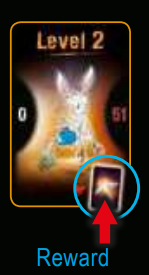

In [156]:
display_base64_image(b64)

### RE RANK the documents

il reranking mi sposta la corretta in fondo... non ha senso, nell'esempio dovrebbe essere la terza, ma me la sposta verso il fondo

In [ ]:
# from langchain_nvidia_ai_endpoints import NVIDIARerank

# reranker = NVIDIARerank()

In [3]:
# from transformers import pipeline

# # Check if GPU is available
# device = 0 if torch.cuda.is_available() else -1

# reranker = pipeline("text-classification", model="cross-encoder/ms-marco-MiniLM-L-6-v2", device=device)
# pairs = [{"text": f"{question} [SEP] {doc}"} for doc in result]
# scores = reranker(pairs)

# for doc, result in zip(result, scores):
#     print(f"Document: {doc}\nScore: {result['score']}\n")

In [200]:
result = []
question = "what are and which types of materia are there in this game?"
one = "Unlock"
two = "The Mind Extreme"
three = "Spellbook"
metadata_filter = {'key': 'metadata.game_name', 'value': three}
#if doesnt find docs, retry the query with lower threshold
similarity_threshold = 0.95
decrease = 0.01
min_documents = 3
while similarity_threshold > decrease and len(result) < min_documents:
    try:
        result, game_id, image_metadata = retrieve_query(question, k = 10, metadata_filter = metadata_filter, similarity_threshold=similarity_threshold)
        similarity_threshold -= decrease
        if len(result) >= min_documents:
            break
    except Exception as e:
        print(f"Error: {e}")
        similarity_threshold -= decrease
        print("setting similarity threshold to", similarity_threshold)
name, description = get_game_details(game_id)
result

Error: retrieve_query() got an unexpected keyword argument 'similarity_threshold'
setting similarity threshold to 0.94
Error: retrieve_query() got an unexpected keyword argument 'similarity_threshold'
setting similarity threshold to 0.9299999999999999
Error: retrieve_query() got an unexpected keyword argument 'similarity_threshold'
setting similarity threshold to 0.9199999999999999
Error: retrieve_query() got an unexpected keyword argument 'similarity_threshold'
setting similarity threshold to 0.9099999999999999
Error: retrieve_query() got an unexpected keyword argument 'similarity_threshold'
setting similarity threshold to 0.8999999999999999
Error: retrieve_query() got an unexpected keyword argument 'similarity_threshold'
setting similarity threshold to 0.8899999999999999
Error: retrieve_query() got an unexpected keyword argument 'similarity_threshold'
setting similarity threshold to 0.8799999999999999
Error: retrieve_query() got an unexpected keyword argument 'similarity_threshold'
s

[]

In [183]:
PROMPT = PromptTemplate(
    template=template_string, input_variables=[ "name", "description", "result", "question"]
)

image_reward_for_game_completion


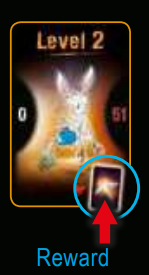

image_blind_symbol_on_side_of_cards


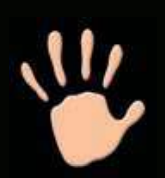

image_course_of_the_game_setup_simple_play_red_white_cards


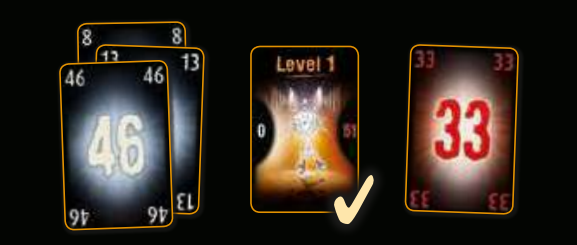

In [130]:
for key, value in image_metadata.items():
    print(key)
    display_base64_image(value)

In [133]:
list(image_metadata.keys())

['image_reward_for_game_completion',
 'image_blind_symbol_on_side_of_cards',
 'image_course_of_the_game_setup_simple_play_red_white_cards']

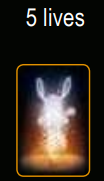

In [125]:
display_base64_image(s)

In [184]:
# Create a Chain object

parser = StrOutputParser()
chain = PROMPT | llm | parser

# async for chunk in chain.astream({"context":result, "question": question, "description": description, "name": name}):
#     print(chunk, end="", flush=True)
res = ""
intermediate_prompt = chain.invoke({"context":result, "question": question, "description": description, "name": name})

In [185]:
intermediate_prompt

'In **Kniha kouzel**, there are three different types of runes that are crucial for the gameplay, particularly when learning spells and using Materia. Here’s a breakdown of each type:\n\n1. **Magma Rune (Red)**: This rune represents the fiery essence of transformation and power. It is often associated with spells that can enhance your abilities or provide aggressive actions.\n\n2. **Poison Rune (Purple)**: This rune embodies the essence of decay and manipulation. Spells associated with this rune may involve strategic control over the game state or affecting other players negatively.\n\n3. **Plant Rune (Green)**: This rune symbolizes growth and nurturing. It is typically linked to spells that allow you to gather resources or enhance your familiar’s capabilities.\n\n4. **Coal Rune (Black)**: This rune signifies the foundation of energy and stability. Spells with this rune might focus on resource management or defensive strategies.\n\n5. **Vapor Rune (White)**: This rune represents fluidi

In [189]:
#altro prompt per inserire le immagini

template_string_final_substitution = """system: Given the context: {context}, and the following list of image IDs, that also describe shortly the image itself: {list_images}, enhance the context by incorporating relevant image IDs as visual recommendations for the final user. 
Ensure that the original content remains unchanged, except for the addition of image references. Aim for a natural integration of the images into the text.
use {list_images} to refer to the images that you insert where specifically needed, e.g. ![<list_images_key>](list_images_key), do not add images where they do not refer to the context
"""

FINAL_PROMPT = PromptTemplate(
    template=template_string_final_substitution,
    input_variables=["context", "list_images"]  # Use a list of strings
)


In [190]:
parser = StrOutputParser()
chain = FINAL_PROMPT | llm | parser

async for chunk in chain.astream({"context":intermediate_prompt, "list_images": list(image_metadata.keys())}):
    print(chunk, end="", flush=True)

In **Kniha kouzel**, there are three different types of runes that are crucial for the gameplay, particularly when learning spells and using Materia. Here’s a breakdown of each type:

1. **Magma Rune (Red)**: This rune represents the fiery essence of transformation and power. It is often associated with spells that can enhance your abilities or provide aggressive actions. ![image_red_magma_materia](image_red_magma_materia)

2. **Poison Rune (Purple)**: This rune embodies the essence of decay and manipulation. Spells associated with this rune may involve strategic control over the game state or affecting other players negatively. ![image_purple_poison_materia](image_purple_poison_materia)

3. **Plant Rune (Green)**: This rune symbolizes growth and nurturing. It is typically linked to spells that allow you to gather resources or enhance your familiar’s capabilities. ![image_green_plant_materia](image_green_plant_materia)

4. **Coal Rune (Black)**: This rune signifies the foundation of en

In [188]:
list(image_metadata.keys())

['image_red_magma_materia',
 'image_purple_poison_materia',
 'image_black_coal_materia',
 'image_blue_mercury_materia',
 'image_green_plant_materia',
 'image_white_vapor_materia',
 'image_yellow_gold_materia',
 'image_runes_3',
 'image_sharing_purple_card',
 'image_classic_game_setup']

In [161]:
txt = """To set up **The Mind Extreme** for 3 players, follow these steps carefully to ensure everything is in order for a smooth game:

1. **Determine Lives and Throwing Stars**:
   - For 3 players, you will start with **3 lives** and **1 throwing star**. Place these face up next to each other on the table. ![image_reward_for_game_completion](image_reward_for_game_completion)

2. **Prepare Level Cards**:
   - Take the level cards and stack them face up next to the lives and throwing stars. For 3 players, you will use levels **1 through 10**, so place these cards in ascending order, with level 1 on top.

3. **Shuffle Number Cards**:
   - Shuffle the 100 number cards (which range from 1 to 50 in two separate decks). 

4. **Deal Cards**:
   - For level 1, each player receives **1 card** from the shuffled deck. Make sure players hold their cards so that others cannot see them.

5. **Set Up for Play**:
   - Place the level stack, lives, and throwing stars in the center of the table where everyone can see them. Ensure that all players are ready to begin. ![image_course_of_the_game_setup_simple_play_red_white_cards](image_course_of_the_game_setup_simple_play_red_white_cards)

6. **Game Start**:
   - Once everyone is ready, players place one hand flat on the table. When all players are ready, they remove their hands, and the game begins!

### Example of Gameplay Setup:
- Let’s say you have players Tim, Sarah, and Linus:
  - Tim takes his card, which is a **12**.
  - Sarah has a **25**.
  - Linus has a **40**.
  
  They will now work together to play their cards in the correct order during the game, with Tim focusing on placing his white cards (ascending) and Linus and Sarah on their red cards (descending). 

### Important Notes:
- Remember that during the game, players cannot communicate about their cards, so they must rely on their instincts and timing.
- If you reach level 3, you will need to play “blind,” laying down the white cards face down, which adds an extra layer of challenge! ![image_blind_symbol_on_side_of_cards](image_blind_symbol_on_side_of_cards)

With everything set up, you're ready to dive into the exciting challenge of **The Mind Extreme**! Enjoy the game, and may you successfully complete all levels!"""

In [178]:
result = []
question = "what are the types of runes in this game?"
one = "Unlock"
two = "The Mind Extreme"
three = "Spellbook"
metadata_filter = {'key': 'metadata.game_name', 'value': three}
#if doesnt find docs, retry the query with lower threshold
similarity_threshold = 0.95
decrease = 0.01
min_documents = 3

result, game_id, image_metadata = retrieve_query(question, k = 10, metadata_filter = metadata_filter, embedding_model=embedding_model, qdrant_client=qdrant_client, vector_store=vector_store)
similarity_threshold -= decrease

name, description = get_game_details(game_id)
result

["## Blue Spells  \n### Transmutation (Evening )  \n![12_Image_1.Png](12_Image_1.Png)  \nLevel 5: The player may Learn 1 Spell, but instead of spending sets of 3 identical runes as a wild Materia, they may spend 2 runes matching the rune on this card, each counting as a wild Materia. Worth 4 points at the end of the game.  \nLevel 4: The player may Learn 1 Spell, but instead of spending sets of 3 identical runes as a wild Materia, they may spend 1 rune matching the rune on this card as a wild Materia. Worth 4 points at the end of the game.  \nLevel 3: No effect. Worth 4 points at the end of the game.  \nNote: The rune shown on the Materia placed on the Spell determines which rune can be used as wild Materia when taking this action. When used, this Spell's action replaces the Learn 1 Spell primary action; this means that if the player uses this Spell, they cannot create additional wild Materia using 3 identical runes. The primary action is still available to use, but it cannot be combin

In [4]:
import requests
from bs4 import BeautifulSoup

def get_game_details(game_id):
    # Step 3: Use the ID to retrieve game details from the API
    api_url = f"https://boardgamegeek.com/xmlapi/boardgame/{game_id}"
    response = requests.get(api_url)
    
    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'xml')
        # Extracting the description of the game
        name = soup.find('name').text
        description = soup.find('description').text
        return (name, description)
    else:
        print("Failed to retrieve game details.")
        return None
    

get_game_details(239307)

('Unlock: Különös kalandok',
 'Unlock! Secret Adventures features three &quot;escape room&quot; scenarios that you can play on your tabletop.<br/><br/>Unlock! is a cooperative card game inspired by escape rooms that uses a simple system which allows you to search scenes, combine objects, and solve riddles. Play Unlock! to embark on great adventures, while seated at a table using only cards and a companion app that can provide clues, check codes, monitor time remaining, etc. The three scenarios are...<br/><br/><br/>    &quot;A Noside Story&quot;<br/>    &quot;Tombstone Express&quot;<br/>    &quot;The Adventurers of Oz&quot;<br/><br/><br/>')